# Load in the dataset:

In [ ]:
from google.colab import drive

# Mount Google Drive to access files and folders
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Thesis code/healthy_scab_LDs/'
train_path = '/content/drive/MyDrive/Thesis code/healthy_scab_LDs/training/'
val_path = '/content/drive/MyDrive/Thesis code/healthy_scab_LDs/validation/'
train_val_path = '/content/drive/MyDrive/Thesis code/healthy_scab_LDs/train_val'
test_path = '/content/drive/MyDrive/Thesis code/healthy_scab_LDs/test/'

# Download/import libraries

In [ ]:
!pip install timm
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.5 MB/s eta 0:00:00


In [ ]:
import os
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import timm
from optuna.trial import TrialState
from torchvision import datasets
from torchvision import transforms

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


# Model Maxvit

In [ ]:
timm.list_models('*maxvit*', pretrained=True) # 'maxvit_rmlp_small_rw_224'

['maxvit_base_tf_224.in1k',
 'maxvit_base_tf_224.in21k',
 'maxvit_base_tf_384.in1k',
 'maxvit_base_tf_384.in21k_ft_in1k',
 'maxvit_base_tf_512.in1k',
 'maxvit_base_tf_512.in21k_ft_in1k',
 'maxvit_large_tf_224.in1k',
 'maxvit_large_tf_224.in21k',
 'maxvit_large_tf_384.in1k',
 'maxvit_large_tf_384.in21k_ft_in1k',
 'maxvit_large_tf_512.in1k',
 'maxvit_large_tf_512.in21k_ft_in1k',
 'maxvit_nano_rw_256.sw_in1k',
 'maxvit_rmlp_base_rw_224.sw_in12k',
 'maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k',
 'maxvit_rmlp_base_rw_384.sw_in12k_ft_in1k',
 'maxvit_rmlp_nano_rw_256.sw_in1k',
 'maxvit_rmlp_pico_rw_256.sw_in1k',
 'maxvit_rmlp_small_rw_224.sw_in1k',
 'maxvit_rmlp_tiny_rw_256.sw_in1k',
 'maxvit_small_tf_224.in1k',
 'maxvit_small_tf_384.in1k',
 'maxvit_small_tf_512.in1k',
 'maxvit_tiny_rw_224.sw_in1k',
 'maxvit_tiny_tf_224.in1k',
 'maxvit_tiny_tf_384.in1k',
 'maxvit_tiny_tf_512.in1k',
 'maxvit_xlarge_tf_224.in21k',
 'maxvit_xlarge_tf_384.in21k_ft_in1k',
 'maxvit_xlarge_tf_512.in21k_ft_in1k']

In [ ]:
from sklearn import metrics
from sklearn.metrics import f1_score


# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define parameters
BATCHSIZE = 16
epochs = 100

# Calculate class weights
train_dataset = ImageFolder(train_path)
targets = train_dataset.targets
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)

class_weights_tensor = torch.from_numpy(class_weights)
class_weights_tensor = class_weights_tensor.to(torch.float32)

class_weights_tensor = class_weights_tensor.to(DEVICE)



def define_model(trial):
  model = timm.create_model('maxvit_tiny_rw_224', pretrained=True, in_chans=3) 
  
  for param in model.parameters():
    param.requires_grad = False
    
  num_in_features = model.get_classifier().in_features
    
  head = []
  head.append(nn.BatchNorm1d(num_in_features))
  hidden_layers = trial.suggest_int('hidden_layers', 1, 2)
  for i in range(hidden_layers):
    first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512])
    head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
    head.append(nn.ReLU())
    drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
    head.append(nn.Dropout(p=drop_out))
    num_in_features = first_neuron
    
  head.append(nn.Linear(in_features=num_in_features, out_features=2))
  
  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():      
    param.requires_grad = True

  return model

def get_dataset():
  import torchvision.transforms as transforms
  from torchvision.datasets import ImageFolder

  transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
  
  transform_valid = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  
  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)
  
  train_data = next(iter(train_loader))
  valid_data = next(iter(valid_loader))

  return train_loader, valid_loader

def objective(trial):
  
    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Generate a loss function

    # Define your loss function with class_weights_tensor
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_dataset()

    # Initialize variables for early stopping
    best_loss = 1000000
    patience = 5
    no_improvement_count = 0

    # Train the model with early stopping
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        best_f1_score = 0.0
        total_train = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()    # Backpropagate the gradients
            optimizer.step()   # Update the model parameters

            running_loss += loss.item()

            # Compute the train accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Compute the train loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct_train / total_train

        # Evaluate the model on the validation set
        model.eval()
        correct_valid = 0
        total_valid = 0
        y_true, y_pred = [], []
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)

                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

                y_true += labels.cpu().tolist()
                y_pred += predicted.cpu().tolist()

        # Compute the validation loss and accuracy
        valid_loss /= len(valid_loader)
        valid_accuracy = 100.0 * correct_valid / total_valid


        #calculate the macro f1-score
        f1_score = metrics.f1_score(y_true, y_pred, average='macro')

        # Print the results for this epoch
        print(f"Epoch {epoch}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%, F1_score: {f1_score:.4f}")

        # Report the intermediate result
        trial.report(f1_score, epoch)

        # Check if the validation loss has improved, and if not, increase the no_improvement_count
        if valid_loss < best_loss:
            best_loss = valid_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if the f1 score has improved
        if f1_score > best_f1_score:
            best_f1_score = f1_score

        # Check if early stopping criterion is met
        if no_improvement_count >= patience:
            print("Early stopping criterion met at epoch {}".format(epoch))
            break

        # Handle pruning based on the intermediate result
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_f1_score


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-05-16 20:41:52,104] A new study created in memory with name: no-name-f7e2f5e3-100c-44db-93a8-5742e752dd7d
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0/100 - Train Loss: 1005.2940, Train Accuracy: 53.30% - Valid Loss: 1.3386, Valid Accuracy: 80.59%, F1_score: 0.5343
Epoch 1/100 - Train Loss: 2.6311, Train Accuracy: 60.31% - Valid Loss: 0.7787, Valid Accuracy: 82.28%, F1_score: 0.4944
Epoch 2/100 - Train Loss: 0.7653, Train Accuracy: 73.07% - Valid Loss: 0.6845, Valid Accuracy: 18.99%, F1_score: 0.1696
Epoch 3/100 - Train Loss: 0.8821, Train Accuracy: 59.61% - Valid Loss: 0.6888, Valid Accuracy: 18.99%, F1_score: 0.1696
Epoch 4/100 - Train Loss: 0.7324, Train Accuracy: 55.96% - Valid Loss: 0.7114, Valid Accuracy: 83.12%, F1_score: 0.4775
Epoch 5/100 - Train Loss: 0.7618, Train Accuracy: 57.78% - Valid Loss: 0.6894, Valid Accuracy: 82.70%, F1_score: 0.4527
Epoch 6/100 - Train Loss: 0.7061, Train Accuracy: 61.99% - Valid Loss: 0.7132, Valid Accuracy: 82.70%, F1_score: 0.4527


[I 2023-05-16 21:17:15,895] Trial 0 finished with value: 0.4526558891454965 and parameters: {'hidden_layers': 1, 'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.08954433584650486}. Best is trial 0 with value: 0.4526558891454965.


Epoch 7/100 - Train Loss: 0.7060, Train Accuracy: 70.83% - Valid Loss: 0.6887, Valid Accuracy: 82.70%, F1_score: 0.4527
Early stopping criterion met at epoch 7
Epoch 0/100 - Train Loss: 33.3398, Train Accuracy: 53.58% - Valid Loss: 1.0809, Valid Accuracy: 17.30%, F1_score: 0.1475
Epoch 1/100 - Train Loss: 0.8181, Train Accuracy: 64.66% - Valid Loss: 0.7192, Valid Accuracy: 17.30%, F1_score: 0.1475
Epoch 2/100 - Train Loss: 0.6998, Train Accuracy: 62.27% - Valid Loss: 0.6967, Valid Accuracy: 82.70%, F1_score: 0.4527
Epoch 3/100 - Train Loss: 0.6967, Train Accuracy: 61.85% - Valid Loss: 0.7012, Valid Accuracy: 82.70%, F1_score: 0.4527
Epoch 4/100 - Train Loss: 0.6971, Train Accuracy: 82.61% - Valid Loss: 0.7028, Valid Accuracy: 82.70%, F1_score: 0.4527
Epoch 5/100 - Train Loss: 0.7056, Train Accuracy: 69.57% - Valid Loss: 0.6995, Valid Accuracy: 17.30%, F1_score: 0.1475
Epoch 6/100 - Train Loss: 0.6973, Train Accuracy: 66.48% - Valid Loss: 0.6976, Valid Accuracy: 17.30%, F1_score: 0.1475

[I 2023-05-16 22:14:38,060] Trial 1 finished with value: 0.4526558891454965 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.08069485654548902}. Best is trial 0 with value: 0.4526558891454965.


Epoch 13/100 - Train Loss: 0.6932, Train Accuracy: 62.41% - Valid Loss: 0.6990, Valid Accuracy: 82.70%, F1_score: 0.4527
Early stopping criterion met at epoch 13
Epoch 0/100 - Train Loss: 1.4528, Train Accuracy: 62.13% - Valid Loss: 0.5240, Valid Accuracy: 72.57%, F1_score: 0.6432
Epoch 1/100 - Train Loss: 0.6299, Train Accuracy: 75.60% - Valid Loss: 0.5901, Valid Accuracy: 83.12%, F1_score: 0.7209
Epoch 2/100 - Train Loss: 0.6819, Train Accuracy: 72.79% - Valid Loss: 0.6816, Valid Accuracy: 57.38%, F1_score: 0.5447
Epoch 3/100 - Train Loss: 0.5574, Train Accuracy: 74.33% - Valid Loss: 0.4120, Valid Accuracy: 87.34%, F1_score: 0.7830
Epoch 4/100 - Train Loss: 0.5848, Train Accuracy: 71.25% - Valid Loss: 0.8676, Valid Accuracy: 87.34%, F1_score: 0.6760
Epoch 5/100 - Train Loss: 0.5622, Train Accuracy: 76.72% - Valid Loss: 0.4324, Valid Accuracy: 78.06%, F1_score: 0.7217
Epoch 6/100 - Train Loss: 0.5362, Train Accuracy: 75.74% - Valid Loss: 0.4215, Valid Accuracy: 82.28%, F1_score: 0.737

[I 2023-05-16 23:13:54,759] Trial 2 finished with value: 0.7882168058422951 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.0022008887945337945}. Best is trial 2 with value: 0.7882168058422951.


Epoch 13/100 - Train Loss: 0.4507, Train Accuracy: 81.49% - Valid Loss: 0.5840, Valid Accuracy: 87.76%, F1_score: 0.7882
Early stopping criterion met at epoch 13
Epoch 0/100 - Train Loss: 0.7079, Train Accuracy: 66.48% - Valid Loss: 0.6975, Valid Accuracy: 42.62%, F1_score: 0.4216
Epoch 1/100 - Train Loss: 0.6053, Train Accuracy: 69.28% - Valid Loss: 0.4731, Valid Accuracy: 70.04%, F1_score: 0.6473
Epoch 2/100 - Train Loss: 0.5416, Train Accuracy: 73.49% - Valid Loss: 0.4057, Valid Accuracy: 83.97%, F1_score: 0.7627
Epoch 3/100 - Train Loss: 0.5016, Train Accuracy: 75.74% - Valid Loss: 0.4591, Valid Accuracy: 71.31%, F1_score: 0.6494
Epoch 4/100 - Train Loss: 0.5078, Train Accuracy: 77.84% - Valid Loss: 0.3851, Valid Accuracy: 81.01%, F1_score: 0.7353
Epoch 5/100 - Train Loss: 0.5333, Train Accuracy: 76.16% - Valid Loss: 0.4377, Valid Accuracy: 77.22%, F1_score: 0.7081
Epoch 6/100 - Train Loss: 0.5031, Train Accuracy: 77.84% - Valid Loss: 0.3919, Valid Accuracy: 77.64%, F1_score: 0.705

[I 2023-05-17 00:27:24,311] Trial 3 finished with value: 0.8070451584889274 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.0022686547437160936}. Best is trial 3 with value: 0.8070451584889274.


Epoch 17/100 - Train Loss: 0.5176, Train Accuracy: 77.28% - Valid Loss: 0.3787, Valid Accuracy: 87.34%, F1_score: 0.8070
Early stopping criterion met at epoch 17
Epoch 0/100 - Train Loss: 1.2345, Train Accuracy: 55.96% - Valid Loss: 0.6910, Valid Accuracy: 82.28%, F1_score: 0.4944
Epoch 1/100 - Train Loss: 0.6430, Train Accuracy: 67.46% - Valid Loss: 0.4724, Valid Accuracy: 73.84%, F1_score: 0.6745
Epoch 2/100 - Train Loss: 0.6394, Train Accuracy: 61.71% - Valid Loss: 0.4836, Valid Accuracy: 83.12%, F1_score: 0.7632
Epoch 3/100 - Train Loss: 0.5819, Train Accuracy: 73.91% - Valid Loss: 0.6411, Valid Accuracy: 50.21%, F1_score: 0.4835
Epoch 4/100 - Train Loss: 0.5575, Train Accuracy: 74.33% - Valid Loss: 0.8815, Valid Accuracy: 51.48%, F1_score: 0.4940
Epoch 5/100 - Train Loss: 0.5154, Train Accuracy: 76.58% - Valid Loss: 0.5321, Valid Accuracy: 63.29%, F1_score: 0.5857


[I 2023-05-17 00:56:03,047] Trial 4 finished with value: 0.5950102529049897 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.009223234666761781}. Best is trial 3 with value: 0.8070451584889274.


Epoch 6/100 - Train Loss: 0.5621, Train Accuracy: 74.61% - Valid Loss: 0.6218, Valid Accuracy: 83.12%, F1_score: 0.5950
Early stopping criterion met at epoch 6
Epoch 0/100 - Train Loss: 0.7042, Train Accuracy: 68.16% - Valid Loss: 0.5685, Valid Accuracy: 59.07%, F1_score: 0.5606
Epoch 1/100 - Train Loss: 0.5560, Train Accuracy: 70.27% - Valid Loss: 0.4626, Valid Accuracy: 70.89%, F1_score: 0.6517
Epoch 2/100 - Train Loss: 0.5597, Train Accuracy: 73.91% - Valid Loss: 0.5038, Valid Accuracy: 68.35%, F1_score: 0.6356
Epoch 3/100 - Train Loss: 0.4836, Train Accuracy: 76.16% - Valid Loss: 0.6205, Valid Accuracy: 52.74%, F1_score: 0.5063
Epoch 4/100 - Train Loss: 0.5462, Train Accuracy: 74.05% - Valid Loss: 0.5380, Valid Accuracy: 64.98%, F1_score: 0.6048
Epoch 5/100 - Train Loss: 0.4733, Train Accuracy: 77.70% - Valid Loss: 0.4853, Valid Accuracy: 62.45%, F1_score: 0.5863


[I 2023-05-17 01:24:36,867] Trial 5 finished with value: 0.5780959752321981 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.002801846985488616}. Best is trial 3 with value: 0.8070451584889274.


Epoch 6/100 - Train Loss: 0.5152, Train Accuracy: 76.58% - Valid Loss: 0.5219, Valid Accuracy: 61.18%, F1_score: 0.5781
Early stopping criterion met at epoch 6


[I 2023-05-17 01:28:47,403] Trial 6 pruned. 


Epoch 0/100 - Train Loss: 0.9661, Train Accuracy: 62.97% - Valid Loss: 0.7669, Valid Accuracy: 51.48%, F1_score: 0.4940
Epoch 0/100 - Train Loss: 2.2206, Train Accuracy: 59.33% - Valid Loss: 0.6323, Valid Accuracy: 63.29%, F1_score: 0.5644


[I 2023-05-17 01:37:13,967] Trial 7 pruned. 


Epoch 1/100 - Train Loss: 0.6837, Train Accuracy: 66.90% - Valid Loss: 0.5053, Valid Accuracy: 64.56%, F1_score: 0.6061
Epoch 0/100 - Train Loss: 0.6897, Train Accuracy: 67.46% - Valid Loss: 0.6836, Valid Accuracy: 60.34%, F1_score: 0.5154


[I 2023-05-17 01:45:38,891] Trial 8 pruned. 


Epoch 1/100 - Train Loss: 0.6756, Train Accuracy: 78.96% - Valid Loss: 0.6753, Valid Accuracy: 52.74%, F1_score: 0.4962
Epoch 0/100 - Train Loss: 0.6744, Train Accuracy: 77.56% - Valid Loss: 0.6419, Valid Accuracy: 69.62%, F1_score: 0.6255


[I 2023-05-17 01:53:57,656] Trial 9 pruned. 


Epoch 1/100 - Train Loss: 0.6158, Train Accuracy: 70.41% - Valid Loss: 0.5679, Valid Accuracy: 56.96%, F1_score: 0.5412
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  0.8070451584889274
  Params: 
    hidden_layers: 2
    first_neuron: 512
    drop_out: 0.3
    optimizer: AdamW
    lr: 0.0022686547437160936


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.452656,2023-05-16 20:41:52.107103,2023-05-16 21:17:15.895140,0 days 00:35:23.788037,0.3,128,1,0.089544,RMSprop,COMPLETE
1,1,0.452656,2023-05-16 21:17:15.896729,2023-05-16 22:14:38.060241,0 days 00:57:22.163512,0.0,256,2,0.080695,Adam,COMPLETE
2,2,0.788217,2023-05-16 22:14:38.061845,2023-05-16 23:13:54.758705,0 days 00:59:16.696860,0.3,512,1,0.002201,RMSprop,COMPLETE
3,3,0.807045,2023-05-16 23:13:54.760471,2023-05-17 00:27:24.310727,0 days 01:13:29.550256,0.3,512,2,0.002269,AdamW,COMPLETE
4,4,0.595010,2023-05-17 00:27:24.312450,2023-05-17 00:56:03.046700,0 days 00:28:38.734250,0.5,256,2,0.009223,Adam,COMPLETE
5,5,0.578096,2023-05-17 00:56:03.048239,2023-05-17 01:24:36.867409,0 days 00:28:33.819170,0.0,256,2,0.002802,AdamW,COMPLETE
6,6,0.494013,2023-05-17 01:24:36.869050,2023-05-17 01:28:47.403269,0 days 00:04:10.534219,0.5,256,1,0.006119,AdamW,PRUNED
7,7,0.606125,2023-05-17 01:28:47.404566,2023-05-17 01:37:13.967277,0 days 00:08:26.562711,0.5,256,2,0.003222,RMSprop,PRUNED
8,8,0.496204,2023-05-17 01:37:13.969047,2023-05-17 01:45:38.891448,0 days 00:08:24.922401,0.3,256,2,0.000041,RMSprop,PRUNED
9,9,0.541186,2023-05-17 01:45:38.892823,2023-05-17 01:53:57.655987,0 days 00:08:18.763164,0.3,128,2,0.000591,AdamW,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

# Re-train model with best hyperparameters



In [ ]:
from sklearn import metrics
from sklearn.metrics import f1_score

best_hidden_layers = 2 #study.best_params['hidden_layers']
best_neurons = 512# study.best_params['first_neuron']
best_dropout = 0.3 #study.best_params['drop_out']
best_optimizer = 'AdamW' #study.best_params['optimizer']
best_lr = 0.002269 #study.best_params['lr']
BATCHSIZE = 16
epochs = 12


# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weights
train_val_dataset = ImageFolder(train_val_path)
targets = train_val_dataset.targets
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)

class_weights_tensor = torch.from_numpy(class_weights)
class_weights_tensor = class_weights_tensor.to(torch.float32)
class_weights_tensor = class_weights_tensor.to(DEVICE)

def define_model():
  model = timm.create_model('maxvit_tiny_rw_224', pretrained=True, in_chans=3) 
  
  for param in model.parameters():
    param.requires_grad = False
    
  num_in_features = model.get_classifier().in_features
    
  head = []
  head.append(nn.BatchNorm1d(num_in_features))
  for i in range(best_hidden_layers):
    head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
    head.append(nn.ReLU())
    head.append(nn.Dropout(p=best_dropout))
    num_in_features = best_neurons
    
  head.append(nn.Linear(in_features=num_in_features, out_features=2))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():      
    param.requires_grad = True
  
  return model

def get_dataset():
  import torchvision.transforms as transforms
  from torchvision.datasets import ImageFolder

  transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
  
  transform_valid = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  
  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=True)
  
  train_data = next(iter(train_loader))
  valid_data = next(iter(valid_loader))

  from sklearn.utils.class_weight import compute_class_weight
  targets = train_val_dataset.targets
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)
  class_weights = {i : class_weights[i] for i in range(2)}

  print(class_weights)

  return train_loader, valid_loader


# Generate the model.
model = define_model().to(DEVICE)

# Generate the optimizers.
optimizer_name = best_optimizer
lr = best_lr
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

# Generate a loss function
criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)

# Get the FashionMNIST dataset.
train_loader, valid_loader = get_dataset()


train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Train the model with early stopping
for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    best_f1_score = 0.0
    total_train = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()    # Backpropagate the gradients
        optimizer.step()   # Update the model parameters

        running_loss += loss.item()

        # Compute the train accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Compute the train loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct_train / total_train

    # Evaluate the model on the validation set
    model.eval()
    correct_valid = 0
    total_valid = 0
    y_true, y_pred = [], []
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

            y_true += labels.cpu().tolist()
            y_pred += predicted.cpu().tolist()

    # Compute the validation loss and accuracy
    valid_loss /= len(valid_loader)
    valid_accuracy = 100.0 * correct_valid / total_valid

    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    val_losses.append(valid_loss)
    val_accs.append(valid_accuracy)


    #calculate the macro f1-score
    f1_score = metrics.f1_score(y_true, y_pred, average='macro')

    # Print the results for this epoch
    print(f"Epoch {epoch}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train_Val Accuracy: {train_accuracy:.2f}% - "
          f"Valid Loss: {valid_loss:.4f}, Test Accuracy: {valid_accuracy:.2f}%, F1_score: {f1_score:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{0: 2.878787878787879, 1: 0.6050955414012739}
Epoch 0/12 - Train Loss: 0.6865, Train_Val Accuracy: 67.16% - Valid Loss: 0.6145, Test Accuracy: 54.17%, F1_score: 0.5226
Epoch 1/12 - Train Loss: 0.5560, Train_Val Accuracy: 72.95% - Valid Loss: 0.5291, Test Accuracy: 60.83%, F1_score: 0.5741
Epoch 2/12 - Train Loss: 0.5496, Train_Val Accuracy: 76.74% - Valid Loss: 0.7604, Test Accuracy: 34.58%, F1_score: 0.3458
Epoch 3/12 - Train Loss: 0.5019, Train_Val Accuracy: 75.68% - Valid Loss: 0.4485, Test Accuracy: 78.75%, F1_score: 0.7213
Epoch 4/12 - Train Loss: 0.5270, Train_Val Accuracy: 75.58% - Valid Loss: 0.4116, Test Accuracy: 82.50%, F1_score: 0.7457
Epoch 5/12 - Train Loss: 0.4945, Train_Val Accuracy: 77.26% - Valid Loss: 0.4666, Test Accuracy: 80.00%, F1_score: 0.7054
Epoch 6/12 - Train Loss: 0.5132, Train_Val Accuracy: 76.74% - Valid Loss: 0.5275, Test Accuracy: 82.50%, F1_score: 0.7422
Epoch 7/12 - Train Loss: 0.4969, Train_Val Accuracy: 76.32% - Valid Loss: 0.4059, Test Accuracy: 84.

# Test performance on test set

In [ ]:
# Load dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)

from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=32)

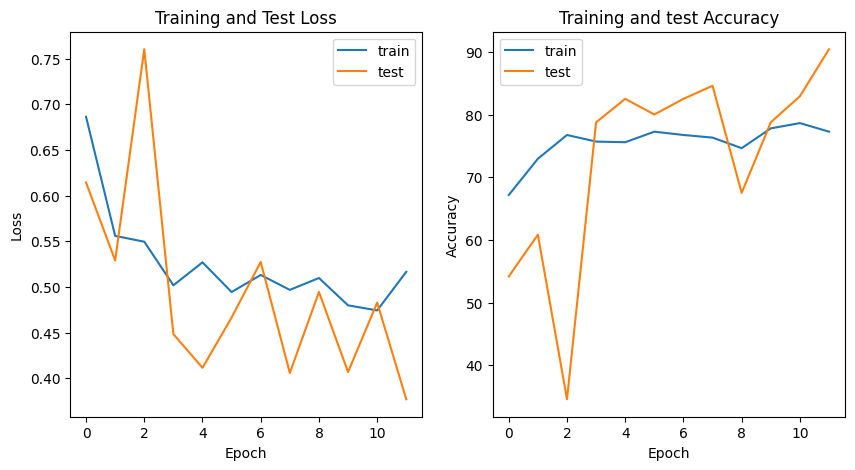

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(val_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(val_accs, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy')
ax[1].legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

model.eval()
correct_test = 0
total_test = 0
test_loss = 0.0
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Append true labels and predicted labels to the respective lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()




# Compute the test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100.0 * correct_test / total_test

# Print the test results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


# Calculate the evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))

Test Loss: 0.3294, Test Accuracy: 90.42%
Accuracy: 0.9041666666666667
Precision: 0.9533678756476683
Recall: 0.9292929292929293
F1-score: 0.9411764705882352
F1_score_macro: 0.8413747521480501
AUC-ROC: 0.8575036075036074

              precision    recall  f1-score   support

           0       0.70      0.79      0.74        42
           1       0.95      0.93      0.94       198

    accuracy                           0.90       240
   macro avg       0.83      0.86      0.84       240
weighted avg       0.91      0.90      0.91       240



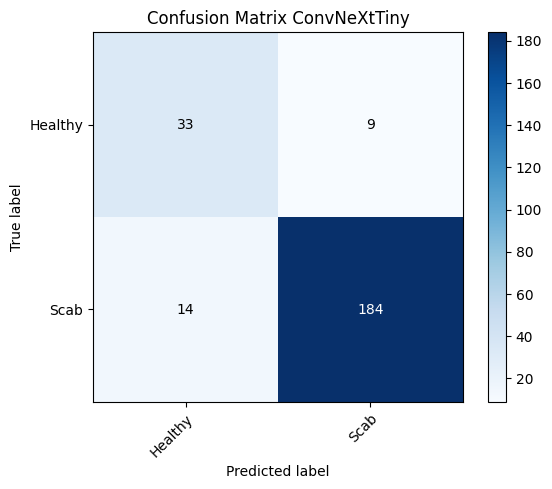

In [ ]:
# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ConvNeXtTiny")
plt.show()

# Model Swin Transformer

In [ ]:
timm.list_models('*swin*', pretrained=True) # 'swin_tiny_patch4_window7_224"'

['swin_base_patch4_window7_224.ms_in1k',
 'swin_base_patch4_window7_224.ms_in22k',
 'swin_base_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_base_patch4_window12_384.ms_in1k',
 'swin_base_patch4_window12_384.ms_in22k',
 'swin_base_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_large_patch4_window7_224.ms_in22k',
 'swin_large_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_large_patch4_window12_384.ms_in22k',
 'swin_large_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_s3_base_224.ms_in1k',
 'swin_s3_small_224.ms_in1k',
 'swin_s3_tiny_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in22k',
 'swin_small_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_tiny_patch4_window7_224.ms_in1k',
 'swin_tiny_patch4_window7_224.ms_in22k',
 'swin_tiny_patch4_window7_224.ms_in22k_ft_in1k',
 'swinv2_base_window8_256.ms_in1k',
 'swinv2_base_window12_192.ms_in22k',
 'swinv2_base_window12to16_192to256.ms_in22k_ft_in1k',
 'swinv2_base_window12to24_192to384.ms_in22k_ft_in1k',


In [ ]:
from sklearn import metrics
from sklearn.metrics import f1_score


# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define parameters
BATCHSIZE = 16
epochs = 100

# Calculate class weights
train_dataset = ImageFolder(train_path)
targets = train_dataset.targets
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)

class_weights_tensor = torch.from_numpy(class_weights)
class_weights_tensor = class_weights_tensor.to(torch.float32)

class_weights_tensor = class_weights_tensor.to(DEVICE)



def define_model(trial):
  model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, in_chans=3) 
  
  for param in model.parameters():
    param.requires_grad = False
    
  num_in_features = model.get_classifier().in_features
    
  head = []
  head.append(nn.BatchNorm1d(num_in_features))
  hidden_layers = trial.suggest_int('hidden_layers', 1, 2)
  for i in range(hidden_layers):
    first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512])
    head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
    head.append(nn.ReLU())
    drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
    head.append(nn.Dropout(p=drop_out))
    num_in_features = first_neuron
    
  head.append(nn.Linear(in_features=num_in_features, out_features=2))
  
  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():      
    param.requires_grad = True

  return model

def get_dataset():
  import torchvision.transforms as transforms
  from torchvision.datasets import ImageFolder

  transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
  
  transform_valid = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  
  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)
  
  train_data = next(iter(train_loader))
  valid_data = next(iter(valid_loader))

  return train_loader, valid_loader

def objective(trial):
  
    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Generate a loss function

    # Define your loss function with class_weights_tensor
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_dataset()

    # Initialize variables for early stopping
    best_loss = 1000000
    patience = 5
    no_improvement_count = 0

    # Train the model with early stopping
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        best_f1_score = 0.0
        total_train = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()    # Backpropagate the gradients
            optimizer.step()   # Update the model parameters

            running_loss += loss.item()

            # Compute the train accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Compute the train loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct_train / total_train

        # Evaluate the model on the validation set
        model.eval()
        correct_valid = 0
        total_valid = 0
        y_true, y_pred = [], []
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)

                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

                y_true += labels.cpu().tolist()
                y_pred += predicted.cpu().tolist()

        # Compute the validation loss and accuracy
        valid_loss /= len(valid_loader)
        valid_accuracy = 100.0 * correct_valid / total_valid


        #calculate the macro f1-score
        f1_score = metrics.f1_score(y_true, y_pred, average='macro')

        # Print the results for this epoch
        print(f"Epoch {epoch}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%, F1_score: {f1_score:.4f}")

        # Report the intermediate result
        trial.report(f1_score, epoch)

        # Check if the validation loss has improved, and if not, increase the no_improvement_count
        if valid_loss < best_loss:
            best_loss = valid_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if the f1 score has improved
        if f1_score > best_f1_score:
            best_f1_score = f1_score

        # Check if early stopping criterion is met
        if no_improvement_count >= patience:
            print("Early stopping criterion met at epoch {}".format(epoch))
            break

        # Handle pruning based on the intermediate result
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_f1_score


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-05-18 08:17:49,624] A new study created in memory with name: no-name-af750f85-3bf5-4127-8e30-a08f68f2f142
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0/100 - Train Loss: 0.7948, Train Accuracy: 67.32% - Valid Loss: 0.6105, Valid Accuracy: 80.17%, F1_score: 0.6804
Epoch 1/100 - Train Loss: 0.5521, Train Accuracy: 75.32% - Valid Loss: 0.4980, Valid Accuracy: 86.92%, F1_score: 0.7692
Epoch 2/100 - Train Loss: 0.4562, Train Accuracy: 79.52% - Valid Loss: 0.4441, Valid Accuracy: 87.34%, F1_score: 0.7869
Epoch 3/100 - Train Loss: 0.5032, Train Accuracy: 77.56% - Valid Loss: 0.5072, Valid Accuracy: 81.86%, F1_score: 0.7026
Epoch 4/100 - Train Loss: 0.4655, Train Accuracy: 79.10% - Valid Loss: 0.4808, Valid Accuracy: 89.45%, F1_score: 0.7976
Epoch 5/100 - Train Loss: 0.4526, Train Accuracy: 81.07% - Valid Loss: 0.4620, Valid Accuracy: 73.84%, F1_score: 0.6803
Epoch 6/100 - Train Loss: 0.3799, Train Accuracy: 83.31% - Valid Loss: 0.4886, Valid Accuracy: 70.89%, F1_score: 0.6545
Epoch 7/100 - Train Loss: 0.4034, Train Accuracy: 84.15% - Valid Loss: 0.3895, Valid Accuracy: 88.61%, F1_score: 0.8132
Epoch 8/100 - Train Loss: 0.3451, Train 

[I 2023-05-18 09:46:41,795] Trial 0 finished with value: 0.8079861111111111 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.0006241657577591948}. Best is trial 0 with value: 0.8079861111111111.


Epoch 20/100 - Train Loss: 0.3513, Train Accuracy: 86.54% - Valid Loss: 0.4099, Valid Accuracy: 88.19%, F1_score: 0.8080
Early stopping criterion met at epoch 20
Epoch 0/100 - Train Loss: 0.6280, Train Accuracy: 67.32% - Valid Loss: 0.4694, Valid Accuracy: 79.75%, F1_score: 0.7228
Epoch 1/100 - Train Loss: 0.4951, Train Accuracy: 77.28% - Valid Loss: 0.4374, Valid Accuracy: 73.00%, F1_score: 0.6700
Epoch 2/100 - Train Loss: 0.4633, Train Accuracy: 80.22% - Valid Loss: 0.4024, Valid Accuracy: 84.81%, F1_score: 0.7783
Epoch 3/100 - Train Loss: 0.4537, Train Accuracy: 78.82% - Valid Loss: 0.3949, Valid Accuracy: 85.23%, F1_score: 0.7798
Epoch 4/100 - Train Loss: 0.3869, Train Accuracy: 82.19% - Valid Loss: 0.4048, Valid Accuracy: 85.65%, F1_score: 0.7707
Epoch 5/100 - Train Loss: 0.4002, Train Accuracy: 84.15% - Valid Loss: 0.4025, Valid Accuracy: 74.26%, F1_score: 0.6895
Epoch 6/100 - Train Loss: 0.3955, Train Accuracy: 81.77% - Valid Loss: 0.3682, Valid Accuracy: 84.81%, F1_score: 0.784

[I 2023-05-18 11:09:15,348] Trial 1 finished with value: 0.7646360663679304 and parameters: {'hidden_layers': 1, 'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.00036675371941268767}. Best is trial 0 with value: 0.8079861111111111.


Epoch 19/100 - Train Loss: 0.3240, Train Accuracy: 87.38% - Valid Loss: 0.3790, Valid Accuracy: 82.70%, F1_score: 0.7646
Early stopping criterion met at epoch 19
Epoch 0/100 - Train Loss: 0.8655, Train Accuracy: 62.27% - Valid Loss: 0.9181, Valid Accuracy: 21.94%, F1_score: 0.2084
Epoch 1/100 - Train Loss: 0.6710, Train Accuracy: 60.59% - Valid Loss: 0.5536, Valid Accuracy: 81.43%, F1_score: 0.6930
Epoch 2/100 - Train Loss: 0.6161, Train Accuracy: 73.21% - Valid Loss: 0.6071, Valid Accuracy: 56.54%, F1_score: 0.5377
Epoch 3/100 - Train Loss: 0.5987, Train Accuracy: 73.91% - Valid Loss: 0.4410, Valid Accuracy: 87.76%, F1_score: 0.8028
Epoch 4/100 - Train Loss: 0.5270, Train Accuracy: 79.94% - Valid Loss: 0.5700, Valid Accuracy: 62.87%, F1_score: 0.5898
Epoch 5/100 - Train Loss: 0.4702, Train Accuracy: 81.35% - Valid Loss: 0.4664, Valid Accuracy: 88.19%, F1_score: 0.7852
Epoch 6/100 - Train Loss: 0.4889, Train Accuracy: 79.24% - Valid Loss: 0.3753, Valid Accuracy: 86.08%, F1_score: 0.789

[I 2023-05-18 12:19:34,001] Trial 2 finished with value: 0.7492063492063492 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.005938708944174126}. Best is trial 0 with value: 0.8079861111111111.


Epoch 16/100 - Train Loss: 0.4313, Train Accuracy: 84.71% - Valid Loss: 0.3825, Valid Accuracy: 82.70%, F1_score: 0.7492
Early stopping criterion met at epoch 16
Epoch 0/100 - Train Loss: 0.6726, Train Accuracy: 67.88% - Valid Loss: 0.6921, Valid Accuracy: 79.32%, F1_score: 0.4961
Epoch 1/100 - Train Loss: 0.6653, Train Accuracy: 66.20% - Valid Loss: 0.6641, Valid Accuracy: 77.64%, F1_score: 0.5803
Epoch 2/100 - Train Loss: 0.6476, Train Accuracy: 66.90% - Valid Loss: 0.6385, Valid Accuracy: 78.06%, F1_score: 0.6604
Epoch 3/100 - Train Loss: 0.6226, Train Accuracy: 68.16% - Valid Loss: 0.6185, Valid Accuracy: 77.64%, F1_score: 0.6511
Epoch 4/100 - Train Loss: 0.6243, Train Accuracy: 68.02% - Valid Loss: 0.6043, Valid Accuracy: 77.22%, F1_score: 0.6578
Epoch 5/100 - Train Loss: 0.6117, Train Accuracy: 69.28% - Valid Loss: 0.5934, Valid Accuracy: 75.53%, F1_score: 0.6377
Epoch 6/100 - Train Loss: 0.6078, Train Accuracy: 68.30% - Valid Loss: 0.5741, Valid Accuracy: 75.11%, F1_score: 0.657

[I 2023-05-18 15:02:39,931] Trial 3 finished with value: 0.7251035625517812 and parameters: {'hidden_layers': 1, 'first_neuron': 128, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 2.3931551827851706e-05}. Best is trial 0 with value: 0.8079861111111111.


Epoch 38/100 - Train Loss: 0.4605, Train Accuracy: 82.47% - Valid Loss: 0.4498, Valid Accuracy: 79.32%, F1_score: 0.7251
Early stopping criterion met at epoch 38
Epoch 0/100 - Train Loss: 0.6993, Train Accuracy: 79.66% - Valid Loss: 0.6576, Valid Accuracy: 82.70%, F1_score: 0.5158
Epoch 1/100 - Train Loss: 0.6365, Train Accuracy: 73.49% - Valid Loss: 0.5979, Valid Accuracy: 82.70%, F1_score: 0.7061
Epoch 2/100 - Train Loss: 0.5946, Train Accuracy: 74.89% - Valid Loss: 0.5761, Valid Accuracy: 83.12%, F1_score: 0.7159
Epoch 3/100 - Train Loss: 0.5652, Train Accuracy: 74.75% - Valid Loss: 0.5276, Valid Accuracy: 79.32%, F1_score: 0.7187
Epoch 4/100 - Train Loss: 0.5185, Train Accuracy: 77.28% - Valid Loss: 0.5130, Valid Accuracy: 73.84%, F1_score: 0.6682
Epoch 5/100 - Train Loss: 0.4857, Train Accuracy: 80.22% - Valid Loss: 0.5189, Valid Accuracy: 60.76%, F1_score: 0.5701
Epoch 6/100 - Train Loss: 0.4763, Train Accuracy: 78.54% - Valid Loss: 0.4391, Valid Accuracy: 82.70%, F1_score: 0.749

[I 2023-05-18 16:30:32,480] Trial 4 finished with value: 0.8230462916874066 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 6.242368161594818e-05}. Best is trial 4 with value: 0.8230462916874066.


Epoch 20/100 - Train Loss: 0.3271, Train Accuracy: 85.69% - Valid Loss: 0.4134, Valid Accuracy: 89.87%, F1_score: 0.8230
Early stopping criterion met at epoch 20
Epoch 0/100 - Train Loss: 0.6855, Train Accuracy: 68.02% - Valid Loss: 0.6664, Valid Accuracy: 72.15%, F1_score: 0.5395


[I 2023-05-18 16:39:03,000] Trial 5 pruned. 


Epoch 1/100 - Train Loss: 0.6461, Train Accuracy: 68.16% - Valid Loss: 0.6234, Valid Accuracy: 73.84%, F1_score: 0.5951
Epoch 0/100 - Train Loss: 0.7191, Train Accuracy: 62.97% - Valid Loss: 0.5911, Valid Accuracy: 78.90%, F1_score: 0.6877


[I 2023-05-18 16:47:28,166] Trial 6 pruned. 


Epoch 1/100 - Train Loss: 0.5752, Train Accuracy: 72.79% - Valid Loss: 0.5628, Valid Accuracy: 60.34%, F1_score: 0.5666
Epoch 0/100 - Train Loss: 57.9186, Train Accuracy: 59.33% - Valid Loss: 14.3572, Valid Accuracy: 73.84%, F1_score: 0.6127


[I 2023-05-18 16:55:44,897] Trial 7 pruned. 


Epoch 1/100 - Train Loss: 12.0325, Train Accuracy: 65.36% - Valid Loss: 6.0472, Valid Accuracy: 27.43%, F1_score: 0.2705


[I 2023-05-18 17:00:04,485] Trial 8 pruned. 


Epoch 0/100 - Train Loss: 0.7189, Train Accuracy: 36.61% - Valid Loss: 0.6974, Valid Accuracy: 28.69%, F1_score: 0.2856


[I 2023-05-18 17:04:14,420] Trial 9 pruned. 


Epoch 0/100 - Train Loss: 0.6930, Train Accuracy: 41.09% - Valid Loss: 0.6735, Valid Accuracy: 36.71%, F1_score: 0.3657
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  5
  Number of complete trials:  5
Best trial:
  Value:  0.8230462916874066
  Params: 
    hidden_layers: 2
    first_neuron: 512
    drop_out: 0.5
    optimizer: RMSprop
    lr: 6.242368161594818e-05


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.807986,2023-05-18 08:17:49.625947,2023-05-18 09:46:41.794789,0 days 01:28:52.168842,0.0,512,2,0.000624,RMSprop,COMPLETE
1,1,0.764636,2023-05-18 09:46:41.796200,2023-05-18 11:09:15.348220,0 days 01:22:33.552020,0.3,128,1,0.000367,RMSprop,COMPLETE
2,2,0.749206,2023-05-18 11:09:15.349896,2023-05-18 12:19:34.001144,0 days 01:10:18.651248,0.0,512,2,0.005939,AdamW,COMPLETE
3,3,0.725104,2023-05-18 12:19:34.002780,2023-05-18 15:02:39.931145,0 days 02:43:05.928365,0.0,128,1,0.000024,AdamW,COMPLETE
4,4,0.823046,2023-05-18 15:02:39.932601,2023-05-18 16:30:32.479729,0 days 01:27:52.547128,0.5,512,2,0.000062,RMSprop,COMPLETE
5,5,0.595073,2023-05-18 16:30:32.481400,2023-05-18 16:39:03.000204,0 days 00:08:30.518804,0.3,128,1,0.000068,AdamW,PRUNED
6,6,0.566643,2023-05-18 16:39:03.001620,2023-05-18 16:47:28.166213,0 days 00:08:25.164593,0.5,256,1,0.000298,Adam,PRUNED
7,7,0.270508,2023-05-18 16:47:28.167646,2023-05-18 16:55:44.897339,0 days 00:08:16.729693,0.5,256,1,0.063001,AdamW,PRUNED
8,8,0.285648,2023-05-18 16:55:44.898593,2023-05-18 17:00:04.485226,0 days 00:04:19.586633,0.5,128,1,0.000029,Adam,PRUNED
9,9,0.365722,2023-05-18 17:00:04.486461,2023-05-18 17:04:14.420337,0 days 00:04:09.933876,0.0,128,1,0.000060,Adam,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
from sklearn import metrics
from sklearn.metrics import f1_score

best_hidden_layers = study.best_params['hidden_layers']
best_neurons = study.best_params['first_neuron']
best_dropout = study.best_params['drop_out']
best_optimizer = study.best_params['optimizer']
best_lr = study.best_params['lr']
BATCHSIZE = 16
epochs = 15


# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weights
train_val_dataset = ImageFolder(train_val_path)
targets = train_val_dataset.targets
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)

class_weights_tensor = torch.from_numpy(class_weights)
class_weights_tensor = class_weights_tensor.to(torch.float32)
class_weights_tensor = class_weights_tensor.to(DEVICE)

def define_model():
  model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, in_chans=3) 
  
  for param in model.parameters():
    param.requires_grad = False
    
  num_in_features = model.get_classifier().in_features
    
  head = []
  head.append(nn.BatchNorm1d(num_in_features))
  for i in range(best_hidden_layers):
    head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
    head.append(nn.ReLU())
    head.append(nn.Dropout(p=best_dropout))
    num_in_features = best_neurons
    
  head.append(nn.Linear(in_features=num_in_features, out_features=2))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():      
    param.requires_grad = True
  
  return model

def get_dataset():
  import torchvision.transforms as transforms
  from torchvision.datasets import ImageFolder

  transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
  
  transform_valid = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  
  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=True)
  
  train_data = next(iter(train_loader))
  valid_data = next(iter(valid_loader))

  from sklearn.utils.class_weight import compute_class_weight
  targets = train_val_dataset.targets
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)
  class_weights = {i : class_weights[i] for i in range(2)}

  print(class_weights)

  return train_loader, valid_loader


# Generate the model.
model = define_model().to(DEVICE)

# Generate the optimizers.
optimizer_name = best_optimizer
lr = best_lr
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

# Generate a loss function
criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)

# Get the FashionMNIST dataset.
train_loader, valid_loader = get_dataset()

# Train the model with early stopping
for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    best_f1_score = 0.0
    total_train = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()    # Backpropagate the gradients
        optimizer.step()   # Update the model parameters

        running_loss += loss.item()

        # Compute the train accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Compute the train loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct_train / total_train

    # Evaluate the model on the validation set
    model.eval()
    correct_valid = 0
    total_valid = 0
    y_true, y_pred = [], []
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

            y_true += labels.cpu().tolist()
            y_pred += predicted.cpu().tolist()

    # Compute the validation loss and accuracy
    valid_loss /= len(valid_loader)
    valid_accuracy = 100.0 * correct_valid / total_valid


    #calculate the macro f1-score
    f1_score = metrics.f1_score(y_true, y_pred, average='macro')

    # Print the results for this epoch
    print(f"Epoch {epoch}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train_Val Accuracy: {train_accuracy:.2f}% - "
          f"Valid Loss: {valid_loss:.4f}, Test Accuracy: {valid_accuracy:.2f}%, F1_score: {f1_score:.4f}")

{0: 2.878787878787879, 1: 0.6050955414012739}
Epoch 0/15 - Train Loss: 0.7061, Train_Val Accuracy: 80.63% - Valid Loss: 0.6284, Test Accuracy: 84.58%, F1_score: 0.6425
Epoch 1/15 - Train Loss: 0.6226, Train_Val Accuracy: 77.68% - Valid Loss: 0.5718, Test Accuracy: 74.17%, F1_score: 0.6629
Epoch 2/15 - Train Loss: 0.5907, Train_Val Accuracy: 71.79% - Valid Loss: 0.5235, Test Accuracy: 81.67%, F1_score: 0.7221
Epoch 3/15 - Train Loss: 0.5575, Train_Val Accuracy: 74.74% - Valid Loss: 0.4742, Test Accuracy: 77.50%, F1_score: 0.7000
Epoch 4/15 - Train Loss: 0.5092, Train_Val Accuracy: 76.63% - Valid Loss: 0.4275, Test Accuracy: 78.33%, F1_score: 0.7173
Epoch 5/15 - Train Loss: 0.4986, Train_Val Accuracy: 76.00% - Valid Loss: 0.4398, Test Accuracy: 88.33%, F1_score: 0.8017
Epoch 6/15 - Train Loss: 0.4497, Train_Val Accuracy: 84.53% - Valid Loss: 0.4036, Test Accuracy: 73.33%, F1_score: 0.6800
Epoch 7/15 - Train Loss: 0.4757, Train_Val Accuracy: 77.68% - Valid Loss: 0.3557, Test Accuracy: 84.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

model.eval()
correct_test = 0
total_test = 0
test_loss = 0.0
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Append true labels and predicted labels to the respective lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()




# Compute the test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100.0 * correct_test / total_test

# Print the test results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


# Calculate the evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))

Test Loss: 0.2758, Test Accuracy: 88.75%
Accuracy: 0.8875
Precision: 0.9572192513368984
Recall: 0.9040404040404041
F1-score: 0.9298701298701298
F1_score_macro: 0.8228298017771701
AUC-ROC: 0.8567821067821068

              precision    recall  f1-score   support

           0       0.64      0.81      0.72        42
           1       0.96      0.90      0.93       198

    accuracy                           0.89       240
   macro avg       0.80      0.86      0.82       240
weighted avg       0.90      0.89      0.89       240



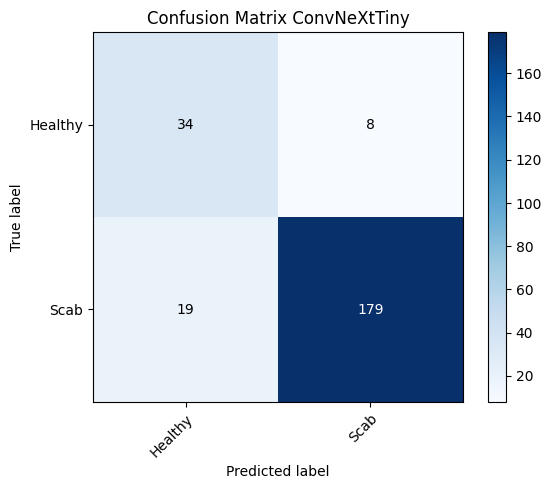

In [ ]:
# Create a confusion matrix:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ConvNeXtTiny")
plt.show()